In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import scipy as sp
import pandas as pd
import io

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# pd.options.display.float_format = '{5:.f}f'.format
# pd.options.plotting.backend = 'plotly'

In [2]:
import pickle

with open('data_filtered/albums.pkl', 'rb') as f:
    albums = pickle.load(f)

with open('data_filtered/artists.pkl', 'rb') as f:
    artists = pickle.load(f)

with open('data_filtered/features.pkl', 'rb') as f:
    features = pickle.load(f)

with open('data_filtered/events.pkl', 'rb') as f:
    events = pickle.load(f)

with open('data_filtered/micro_genre.pkl', 'rb') as f:
    micro_genre = pickle.load(f)

with open('data_filtered/tags.pkl', 'rb') as f:
    tags = pickle.load(f)

with open('data_filtered/tracks.pkl', 'rb') as f:
    tracks = pickle.load(f)

with open('data_filtered/users.pkl', 'rb') as f:
    users = pickle.load(f)


#### Начнем с пользователей

In [3]:
unique_users_from_users = users['user_id'].unique().shape[0]
print(f'Уникальных пользователей в датафрейме `users`: {unique_users_from_users}')

Уникальных пользователей в датафрейме `users`: 710


In [4]:
unique_users_from_event = events['user_id'].unique().shape[0]
print(f'Уникальных пользователей в датафрейме `events`: {unique_users_from_users}')

Уникальных пользователей в датафрейме `events`: 710


Проверили что количество пользователей одинаковое

In [5]:
# Посмотрим распределение по полу

fig = px.histogram(users['gender'], x="gender", text_auto=True, title='Распределение пользователей по полу')
fig.show()

In [6]:
# Возраст
fig = px.histogram(users['age'], x="age", text_auto=True, title='Распределение пользователей по возрасту')
fig.show()

Пользователям возрастом 100+ лет - респект

In [7]:
fig = px.histogram(users['country'], x="country", text_auto=True, title='Распределение стран пользователей')
fig.show()

In [8]:
# Дата создания аккаунта

# Аккуратно преобразуем датафрейм к временному ряду
users_indexing = users.set_index('creation_time').drop(['country', 'age', 'gender'], axis=1)
users_indexing.index = pd.to_datetime(users_indexing.index)

users_indexing = users_indexing.resample('Y').apply({'user_id':'count'})

fig = px.bar(users_indexing, x=users_indexing.index, y="user_id", text_auto=True, title='Распределение даты создания аккаунта')
fig.show()

In [9]:
events_indexing = events.set_index('timestamp')
events_indexing.index = pd.to_datetime(events_indexing.index)
events_indexing = events_indexing.resample('Y').apply({'user_id':'count'})
fig = px.bar(events_indexing, x=events_indexing.index, y="user_id", text_auto=True, title='Распределение прослушиваний по годам')
fig.show()

In [10]:
events_indexing = events.set_index('timestamp')
events_indexing.index = pd.to_datetime(events_indexing.index)
events_indexing = events_indexing.resample('M').apply({'user_id':'count'})
fig = px.bar(events_indexing, x=events_indexing.index, y="user_id", text_auto=True, title='Распределение прослушиваний по месяцам')
fig.show()

In [11]:
events_indexing = events.set_index('timestamp')
events_indexing.index = pd.to_datetime(events_indexing.index)
events_indexing = events_indexing.resample('D').apply({'user_id':'count'})
fig = px.bar(events_indexing, x=events_indexing.index, y="user_id", title='Распределение прослушиваний по дням')
fig.show()

Есть смысл обрезать выборку

Еще можно посмотреть количество прослушиваний по дням недели

In [12]:
# Честно взят кусок Ильи
track_count = events.groupby('track_id').agg(['count', 'nunique']).reset_index()
track_count.columns = ["_".join(a) for a in track_count.columns.to_flat_index()]
track_count = track_count[['track_id_', 'timestamp_count', 'user_id_nunique']]
track_count.columns = ['track_id', 'count', 'unique users']
track_count = track_count.sort_values('count', ascending = False)

In [13]:
top_tracks = track_count.merge(tracks, on='track_id')
top_tracks

,track_id,count,unique users,artist_name,track_name
0,47846265,6454,1,Zona Ganjah,zona ganjah - fumando vamos a casa
1,38214682,4717,37,Evanescence,Sweet Sacrifice
2,23391431,4013,1,Larica dos Mulekes,Larica dos Mulekes - Lanche é Lanche
3,27546184,3499,84,Evanescence,My Immortal
4,20329761,3217,54,Evanescence,Imaginary
...,...,...,...,...,...
1541797,24458143,1,1,Dan Black,Liz & Jonny
1541798,24458158,1,1,Stwo,Liz (Arnold x Lil Texas Remix)
1541799,24458448,1,1,Jim Norton,Liz Taylor's Hairy Hat
1541800,24458517,1,1,Shelagh McDonald,Liz's Song


In [18]:
tracks_with_features = pd.merge(top_tracks, features, left_on=['artist_name', 'track_name'], right_on=['artist','track'], how='inner').drop(['artist', 'track', 'i'], axis=1)
tracks_with_features = tracks_with_features.drop(tracks_with_features[tracks_with_features['count'] < 2].index)
tracks_with_features
# Фичей меньше количества треков

,track_id,count,unique users,artist_name,track_name,token_count,line_count,character_count,stop_word_count,hyphen_count,compression_ratio,entropy
0,14278393,2194,69,Evanescence,Everybody's Fool,181,31,855,98,0,2.050808,4.270534
1,41906239,1823,53,Evanescence,Tourniquet,182,43,815,79,2,2.516320,3.815684
2,25318454,1695,78,The Strokes,Machu Picchu,316,55,1354,133,0,2.285008,4.590445
3,25509112,1412,1,E-Type,Make Us High,173,19,762,87,0,2.252125,4.127944
4,27928333,1384,20,Bob Marley,Natural Mystic,269,37,1266,117,6,3.236318,3.975815
...,...,...,...,...,...,...,...,...,...,...,...,...
195127,33007443,2,1,Entrails,Remains In Red,108,24,600,40,0,1.743802,4.248376
195128,40523836,2,2,Asphyx,The Scent Of Obscurity,80,19,524,25,0,1.564607,4.140514
195129,24362861,2,2,Barenaked Ladies,Little Tiny Song,38,4,124,15,0,1.414414,2.597509
195130,41835035,2,1,Priscilla Ahn,Torch Song,161,26,683,93,0,2.548043,3.651382


In [19]:
tracks_with_features_corr = tracks_with_features.drop(['track_id', 'artist_name', 'track_name'], axis=1).corr()
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = tracks_with_features_corr.columns,
        y = tracks_with_features_corr.index,
        z = np.array(tracks_with_features_corr),
        text=tracks_with_features_corr.values,
        texttemplate='%{text:.2f}',
    )
)
fig.update_layout(title = 'Корреляция Пирсона')
fig.show()


In [20]:
tracks_with_features_corr = tracks_with_features.drop(['track_id', 'artist_name', 'track_name'], axis=1).corr(method='spearman')
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = tracks_with_features_corr.columns,
        y = tracks_with_features_corr.index,
        z = np.array(tracks_with_features_corr),
        text=tracks_with_features_corr.values,
        texttemplate='%{text:.2f}',
    )
)
fig.update_layout(title = 'Корреляция Спирмена')
fig.show()

In [26]:
df = tracks_with_features.drop(['track_id', 'artist_name', 'track_name'], axis=1)

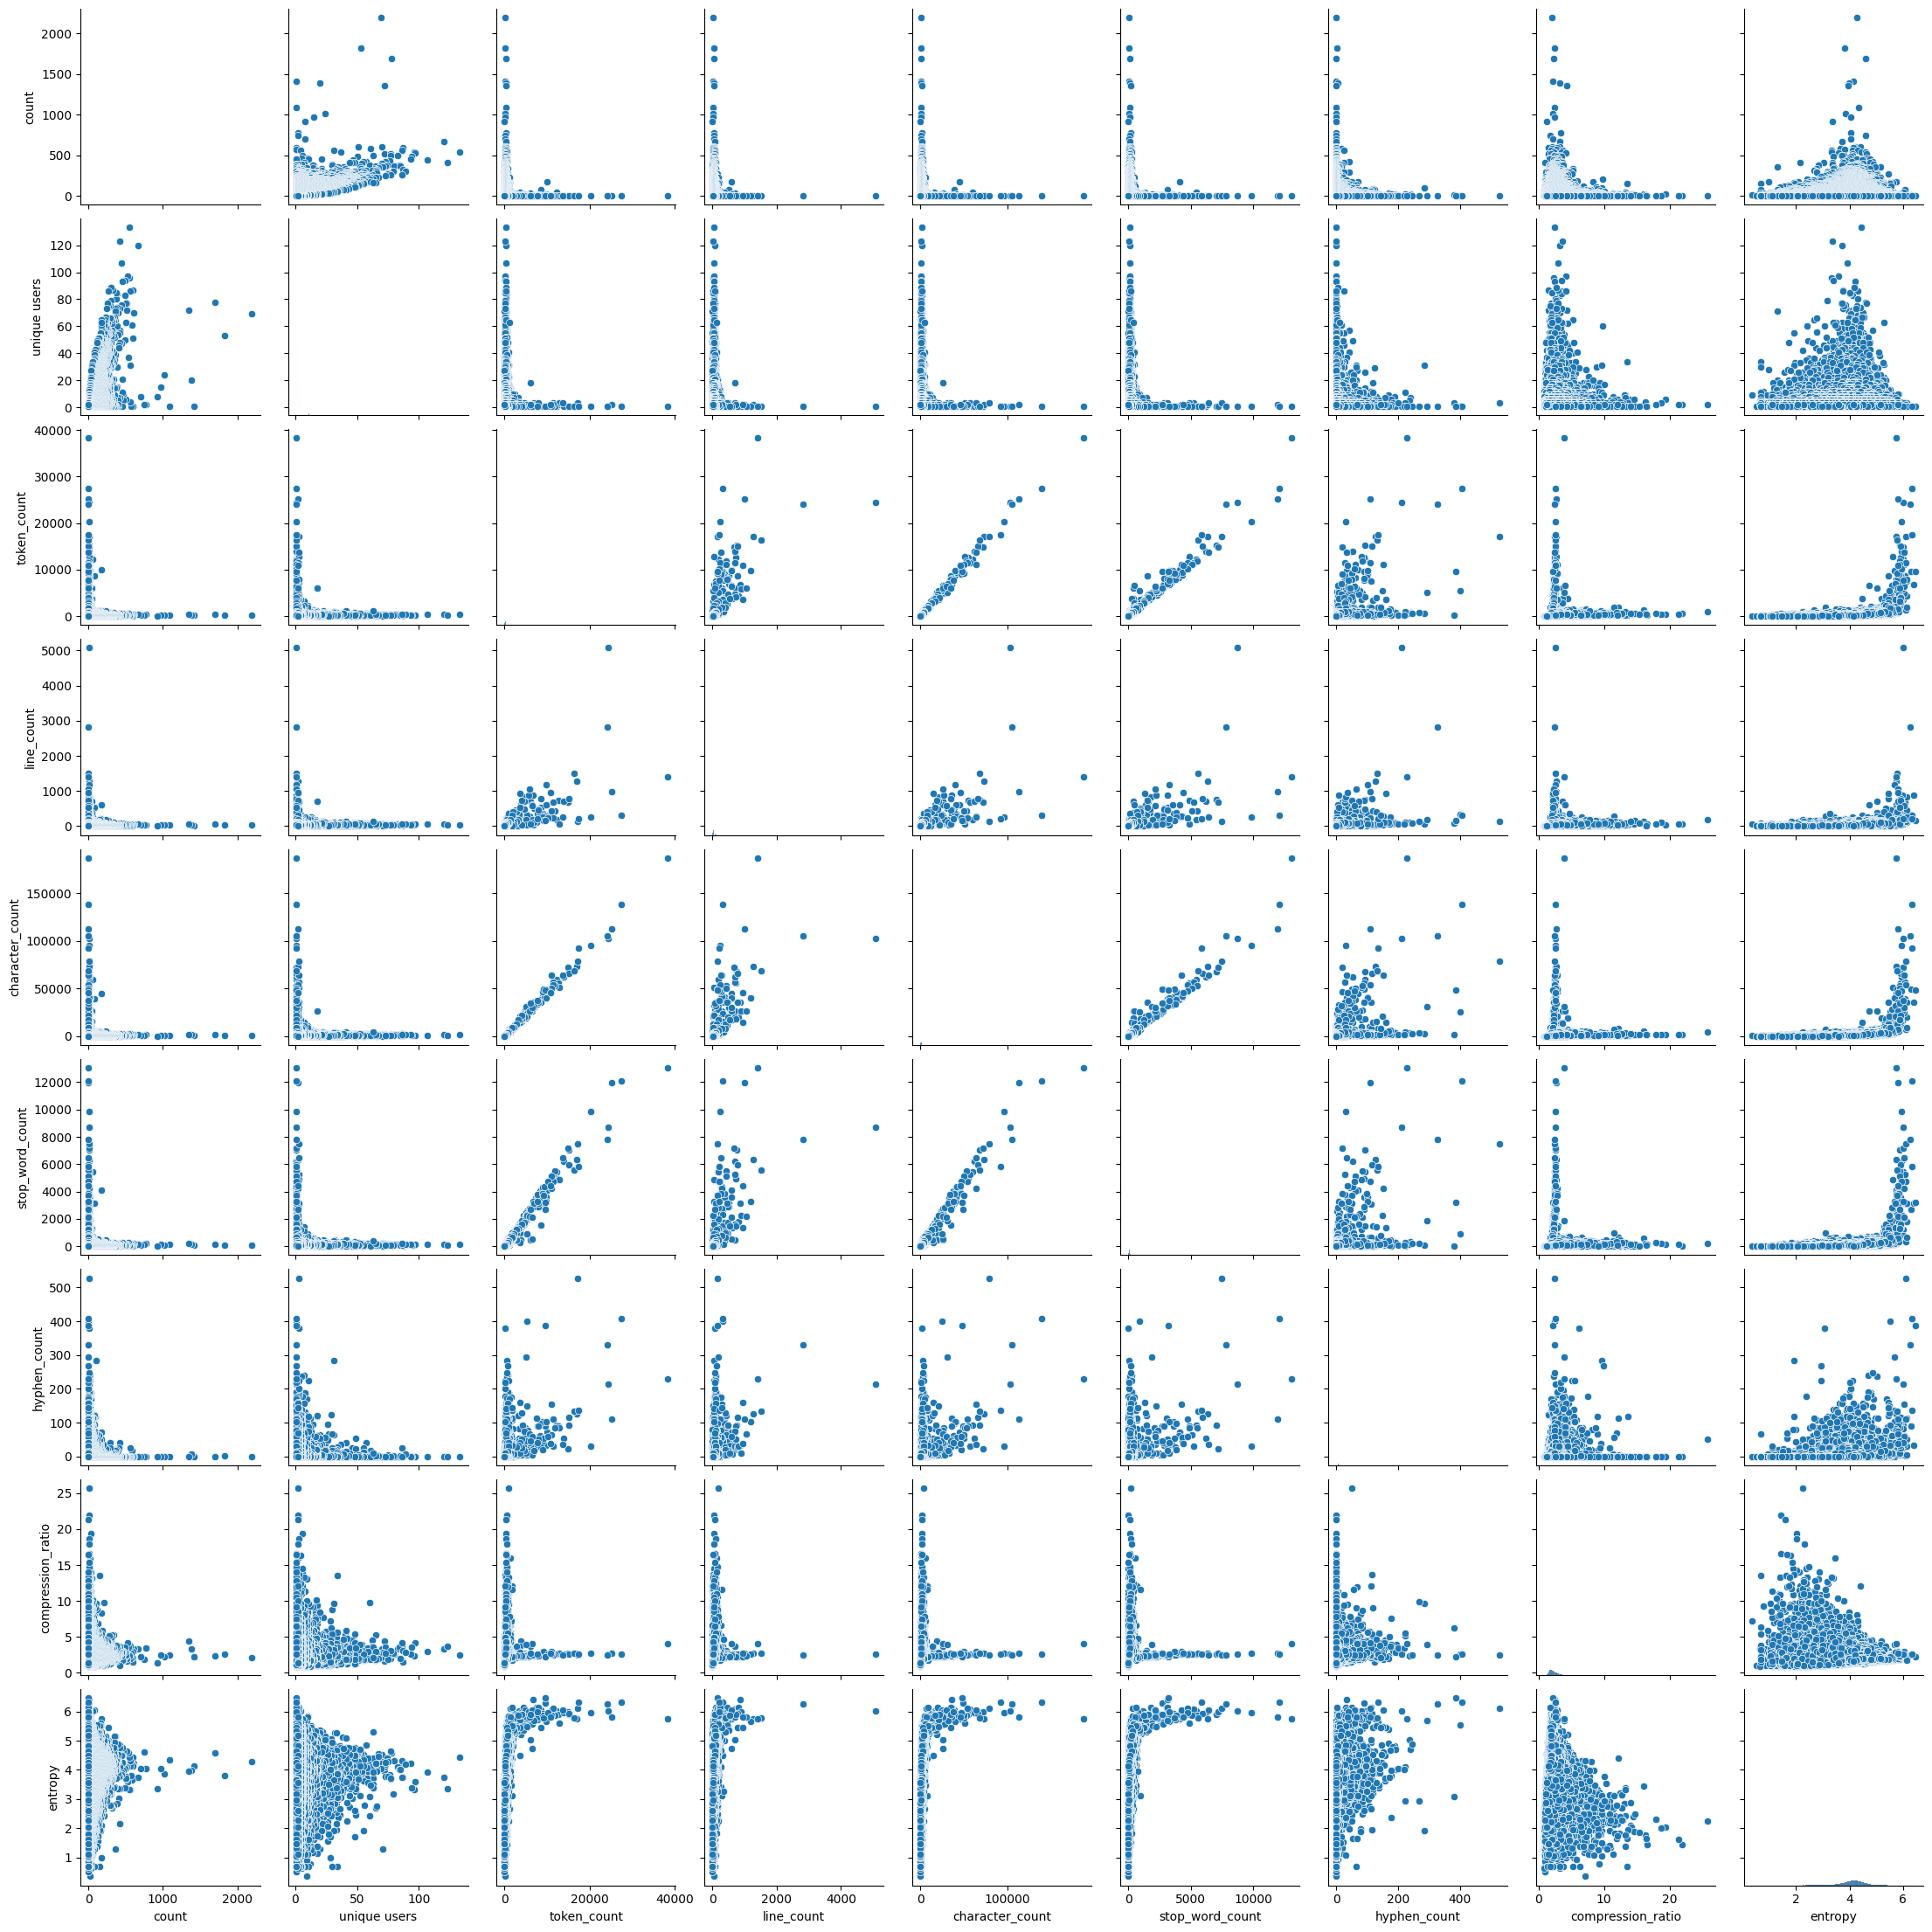

In [25]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(df)
# Заюзал seaborn т.к. plotly не вытянул :(

#### Смержим события, альбомы и треки

In [27]:
events_with_albums = pd.merge(events, albums, on='album_id', how='left')
events_with_albums_and_tracks = pd.merge(events_with_albums, tracks.drop(['artist_name'], axis=1), on='track_id', how='left')
events_with_albums_and_tracks

,user_id,track_id,album_id,timestamp,album_name,artist_name,track_name
0,5090,12533056,8128141,2014-02-08 23:12:09,Don't You Worry Child (Radio Edit) [feat. John...,Swedish House Mafia,Don't You Worry Child (Radio Edit) [feat. John...
1,5090,36383760,8009856,2014-02-08 22:54:39,Discovery,Daft Punk,Something About Us
2,5090,34502741,1677788,2014-02-08 22:20:23,,Skrillex,Scary Monsters and Nice Sprites (Original Mix)
3,5090,33547637,5574231,2014-02-08 22:01:57,Black Magic,Kill the Noise,Rockers
4,5090,44775825,13335902,2014-02-08 21:47:09,MONSTA EP,MONSTA,Where Did I Go? (Dillon Francis & Kill Paris R...
...,...,...,...,...,...,...,...
12059483,29622,40146671,20059465,2009-01-26 12:47:56,The Man Machine,Kraftwerk,The Man Machine
12059484,29622,6245708,6383777,2009-01-26 12:32:39,Cee-Lo Green And His Perfect Imperfections,CeeLo Green,Bass Head Jazz
12059485,29622,41352353,11002160,2009-01-26 12:21:00,Hot On The Tracks,Commodores,Thumpin' Music
12059486,29622,36747225,13229312,2009-01-26 12:07:47,Low,David Bowie,Sound and Vision
